In [1]:
from textblob import TextBlob
import re
from nltk import word_tokenize 
from nltk import pos_tag
import nltk
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from PIL import Image
import numpy as np
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [2]:
df_azure_speech = pd.DataFrame(columns=['Sentence', 'Pre-processed sentence', 'textblob-subjectivity', 'vader-pos', 'vader-neg', 'vader-neu', 'vader-compound', 'vader-polarity', 'sentiment-category'])
pos_words_str_vader = ""
neg_words_str_vader = ""

In [3]:
contractions = {
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had he would",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he shall have he will have",
"he's": "he has he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how has how is",
"i'd": "I had I would",
"i'd've": "I would have",
"i'll": "I shall I will",
"i'll've": "I shall have I will have",
"i'm": "I am",
"i've": "I have",
"isn't": "is not",
"it'd": "it had it would",
"it'd've": "it would have",
"it'll": "it shall it will",
"it'll've": "it shall have it will have",
"it's": "it has it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she had she would",
"she'd've": "she would have",
"she'll": "she shall she will",
"she'll've": "she shall have she will have",
"she's": "she has she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as so is",
"that'd": "that would that had",
"that'd've": "that would have",
"that's": "that has that is",
"there'd": "there had there would",
"there'd've": "there would have",
"there's": "there has there is",
"they'd": "they had they would",
"they'd've": "they would have",
"they'll": "they shall they will",
"they'll've": "they shall have they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what shall what will",
"what'll've": "what shall have / what will have",
"what're": "what are",
"what's": "what has what is",
"what've": "what have",
"when's": "when has when is",
"when've": "when have",
"where'd": "where did",
"where's": "where has where is",
"where've": "where have",
"who'll": "who shall who will",
"who'll've": "who shall have who will have",
"who's": "who has who is",
"who've": "who have",
"why's": "why has why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had you would",
"you'd've": "you would have",
"you'll": "you shall you will",
"you'll've": "you shall have you will have",
"you're": "you are",
"you've": "you have"
}

In [4]:
sentiment_category = {
    'Satisfaction' : ['like', 'love', 'enjoy', 'appreciate'],
    'Dissatisfaction' : ['hate', 'dislike'],
    'Confusion' : ['confusing', 'confused', 'stuck', 'puzzling', 'puzzled'],
    'Expectation' : ['expect', 'hope', 'anticipate'], # think but... hope to find ... look for
    'Suggestion' : ['prefer', 'like better', 'preferable', 'go for', 'favor']
}

In [5]:
with open("e-lekar.txt", 'r') as transcript_sentences:
    text = transcript_sentences.read()

sentences = nltk.tokenize.sent_tokenize(text)

print(sentences)

for sentence in sentences:
    print(sentence)

['I need you to get her here.', 'Clubs.', "If it's time.", 'But at least three times a year in those 3,400.', 'When a doctor has the opportunity to order online, is it always a use of how often?', 'Hmm, I have a choice, none of which are bills of exchange.', 'Often, every month, every moment everyone who does.', 'The site will read it here.', 'It only consults and probably offer to order an online deadline.', "Write, you should have you write down well I'll give a name either I know the name or we'll look up.", "I don't know a neurologist hey looking.", 'Why read?', 'But I see the address phone number there and I see that next free date.', 'Just the address phone number and the next deadline about when it is and when, for example, it does not meet in 3 days, then it is not offered any calendar thus ends.', "That's the next step.", "And the other thing is, for example, I don't know here at all uh.", "That's what I wanted to tell you I don't know is there's a deadline you need the next a

In [6]:
def clean_sentences(text):
    for word in text.split():
        if word.lower() in contractions:
            text = text.replace(word, contractions[word.lower()])
    text = re.sub(r'[^\w\s]', '', text)
    return text

lines_clean = []
for sentence in sentences:
    lines_clean.append(clean_sentences(sentence))
    
print(lines_clean)

['I need you to get her here', 'Clubs', 'If it has it is time', 'But at least three times a year in those 3400', 'When a doctor has the opportunity to order online is it always a use of how often', 'Hmm I have a choice none of which are bills of exchange', 'Often every month every moment everyone who does', 'The site will read it here', 'It only consults and probably offer to order an online deadline', 'Write you should have you write down well I shall I will give a name either I know the name or we will look up', 'I do not know a neurologist hey looking', 'Why read', 'But I see the address phone number there and I see that next free date', 'Just the address phone number and the next deadline about when it is and when for example it does not meet in 3 days then it is not offered any calendar thus ends', 'that has that is the next step', 'And the other thing is for example I do not know here at all uh', 'that has that is what I wanted to tell you I do not know is there has there is a de

In [7]:
pos_dict = {'J': wordnet.ADJ, 'V': wordnet.VERB, 'N': wordnet.NOUN, 'R': wordnet.ADV}
def token_stop_pos(text):
    tags = pos_tag(word_tokenize(str(text)))
    newlist = []
    for word, tag in tags:
        newlist.append(tuple([word, pos_dict.get(tag[0])]))
    return newlist

In [8]:
lines_token_pos = []
for sentence in lines_clean:
    lines_token_pos.append(token_stop_pos(sentence))

print(lines_token_pos)

[[('I', None), ('need', 'v'), ('you', None), ('to', None), ('get', 'v'), ('her', None), ('here', 'r')], [('Clubs', 'n')], [('If', None), ('it', None), ('has', 'v'), ('it', None), ('is', 'v'), ('time', 'n')], [('But', None), ('at', None), ('least', 'a'), ('three', None), ('times', 'n'), ('a', None), ('year', 'n'), ('in', None), ('those', None), ('3400', None)], [('When', None), ('a', None), ('doctor', 'n'), ('has', 'v'), ('the', None), ('opportunity', 'n'), ('to', None), ('order', 'n'), ('online', 'n'), ('is', 'v'), ('it', None), ('always', 'r'), ('a', None), ('use', 'n'), ('of', None), ('how', None), ('often', 'r')], [('Hmm', 'n'), ('I', None), ('have', 'v'), ('a', None), ('choice', 'n'), ('none', 'n'), ('of', None), ('which', None), ('are', 'v'), ('bills', 'n'), ('of', None), ('exchange', 'n')], [('Often', 'r'), ('every', None), ('month', 'n'), ('every', None), ('moment', 'n'), ('everyone', 'n'), ('who', None), ('does', 'v')], [('The', None), ('site', 'n'), ('will', None), ('read', 'v

In [9]:
wordnet_lemmatizer = WordNetLemmatizer()     

In [10]:
def lemmatize_(text):
    lemmatized_sentence = []
    for word, tag in text:
        if tag is None:
            lemmatized_sentence.append(word)
        else:       
            lemmatized_sentence.append(wordnet_lemmatizer.lemmatize(word, tag))
    #lemmatized_sentence = " ".join(lemmatized_sentence)
    
    return lemmatized_sentence

In [11]:
lines_lemma = []
for phrase in lines_token_pos:
    lines_lemma.append(lemmatize_(phrase))

print(lines_lemma)

[['I', 'need', 'you', 'to', 'get', 'her', 'here'], ['Clubs'], ['If', 'it', 'have', 'it', 'be', 'time'], ['But', 'at', 'least', 'three', 'time', 'a', 'year', 'in', 'those', '3400'], ['When', 'a', 'doctor', 'have', 'the', 'opportunity', 'to', 'order', 'online', 'be', 'it', 'always', 'a', 'use', 'of', 'how', 'often'], ['Hmm', 'I', 'have', 'a', 'choice', 'none', 'of', 'which', 'be', 'bill', 'of', 'exchange'], ['Often', 'every', 'month', 'every', 'moment', 'everyone', 'who', 'do'], ['The', 'site', 'will', 'read', 'it', 'here'], ['It', 'only', 'consults', 'and', 'probably', 'offer', 'to', 'order', 'an', 'online', 'deadline'], ['Write', 'you', 'should', 'have', 'you', 'write', 'down', 'well', 'I', 'shall', 'I', 'will', 'give', 'a', 'name', 'either', 'I', 'know', 'the', 'name', 'or', 'we', 'will', 'look', 'up'], ['I', 'do', 'not', 'know', 'a', 'neurologist', 'hey', 'look'], ['Why', 'read'], ['But', 'I', 'see', 'the', 'address', 'phone', 'number', 'there', 'and', 'I', 'see', 'that', 'next', 'fr

In [12]:
stopwords_list = stopwords.words('english')

In [13]:
unwanted = {'no', 'not', 'nor'}
custom_stopwords = [e for e in stopwords_list if e not in unwanted]

In [14]:
def remove_stopwords(text):
    clean_text = []
    for word in text:
        if word.lower() not in set(custom_stopwords):
            clean_text.append(word.lower())
    return clean_text

In [15]:
preprocessed_text = []
for phrase in lines_lemma:
    preprocessed_text.append(remove_stopwords(phrase))

print(preprocessed_text)

[['need', 'get'], ['clubs'], ['time'], ['least', 'three', 'time', 'year', '3400'], ['doctor', 'opportunity', 'order', 'online', 'always', 'use', 'often'], ['hmm', 'choice', 'none', 'bill', 'exchange'], ['often', 'every', 'month', 'every', 'moment', 'everyone'], ['site', 'read'], ['consults', 'probably', 'offer', 'order', 'online', 'deadline'], ['write', 'write', 'well', 'shall', 'give', 'name', 'either', 'know', 'name', 'look'], ['not', 'know', 'neurologist', 'hey', 'look'], ['read'], ['see', 'address', 'phone', 'number', 'see', 'next', 'free', 'date'], ['address', 'phone', 'number', 'next', 'deadline', 'example', 'not', 'meet', '3', 'day', 'not', 'offer', 'calendar', 'thus', 'end'], ['next', 'step'], ['thing', 'example', 'not', 'know', 'uh'], ['want', 'tell', 'not', 'know', 'deadline', 'need', 'next', 'available', 'date', 'not', 'meet', 'show', 'profile', 'ha', 'see', 'hotel', 'accept', 'new', 'full', 'insurance', 'office', 'count', 'not', 'office', 'hour', 'go', 'free', 'show', 'free

In [16]:
analyzer = SentimentIntensityAnalyzer()

In [17]:
new_words = {
    'see': 2.0,
    'find': 2.0,
    'spot': 2.0,
    'grasp': 2.0,
    'perceive': 2.0,
    'identify': 2.0,
    'notice': 2.0,
    'distinguish': 2.0,
    'sight': 2.0,
    'glimpse': 2.0,
    'recognize': 2.0,
    'follow': 2.0,
    'realize': 2.0,
    'discover': 2.0,
    'little': -2.0,
    'small': -2.0,
    'tiny': -2.0,
    'large': 2.0,
}

analyzer.lexicon.update(new_words)

In [18]:
def search(values, searchFor):
    for word in searchFor:
        for k in values:
            for v in values[k]:
                if searchFor in v:
                    return k
    return None

In [19]:
df_azure_speech = pd.DataFrame(columns=['Sentence', 'Pre-processed sentence', 'textblob-subjectivity', 'vader-pos', 'vader-neg', 'vader-neu', 'vader-compound', 'vader-polarity', 'sentiment-category'])
pos_words_str_vader = ""
neg_words_str_vader = ""

In [20]:
for sentence, line in zip(sentences, preprocessed_text):
    line = " ".join(line)
    txtblob_object = TextBlob(line)
    subjectivity = txtblob_object.sentiment.subjectivity
    sentiment_vader = analyzer.polarity_scores(line)
    
    sent_cat = []
    
    if search(sentiment_category, line) is not None:
        sent_cat.append(search(sentiment_category, line))
    
    if sentiment_vader['compound'] < 0:
        polarity = 'Negative'
        neg_words_str_vader += line
        
    elif sentiment_vader['compound'] > 0:
        polarity = 'Positive'
        pos_words_str_vader += line
    else:
        polarity = 'Neutral'
    df_azure_speech = df_azure_speech.append({'Sentence': sentence,'Pre-processed sentence': line, 'textblob-subjectivity': subjectivity, 'vader-pos': sentiment_vader['pos'], 'vader-neg': sentiment_vader['neg'], 'vader-neu':sentiment_vader['neu'], 'vader-compound':sentiment_vader['compound'], 'vader-polarity': polarity, 'sentiment-category': sent_cat}, ignore_index=True)
  

In [21]:
df_azure_speech.to_csv("results_elekar-2.csv")

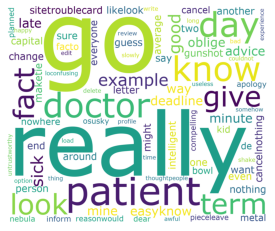

In [22]:
wordcloud = WordCloud(font_path = r'C:\Windows\Fonts\Verdana.ttf',
                            stopwords = STOPWORDS,
                            background_color = 'white',
                            width = 1200,
                            height = 1000,
                            ).generate(neg_words_str_vader)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

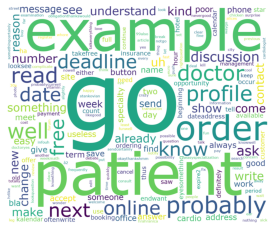

In [23]:
wordcloud = WordCloud(font_path = r'C:\Windows\Fonts\Verdana.ttf',
                            stopwords = STOPWORDS,
                            background_color = 'white',
                            width = 1200,
                            height = 1000,
                            ).generate(pos_words_str_vader)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [24]:
# def sentiment_analysis(textfile):
#     with open(textfile) as transcript:
#         lines = transcript.readlines()
#     lines_clean = clean(lines[0])
#     lines_token_stop_pos = token_stop_pos(lines_clean)
#     lines_lemma = lemmatize(lines_token_stop_pos).lower()
#     ngram_object = TextBlob(lines_lemma)
#     ngrams = ngram_object.ngrams(n=3) 
#     for ngram in ngrams:
#         ngram_str = TextBlob(' '.join(ngram))
#         sentiment = ngram_str.sentiment.polarity
#         subjectivity = ngram_str.sentiment.subjectivity
#         # sentiment_vader = analyzer.polarity_scores(ngram_str)
#         if sentiment >= 0.2:
#             print('Ngram: ' + ' '.join(ngram) + ' | sentiment: ' + str(sentiment) + ' | subjectivity: ' + str(subjectivity))
#         if sentiment < 0:
#             print('Ngram: ' + ' '.join(ngram) + ' | sentiment: ' + str(sentiment) + ' | subjectivity: ' + str(subjectivity))
    
# #     file_content=open (textfile).read()

# #     wordcloud = WordCloud(font_path = r'C:\Windows\Fonts\Verdana.ttf',
# #                             stopwords = STOPWORDS,
# #                             background_color = 'white',
# #                             width = 1200,
# #                             height = 1000,
# #                             color_func = random_color_func
# #                             ).generate(lines_lemma)
# #     plt.imshow(wordcloud)
# #     plt.axis('off')
# #     plt.show()

In [25]:
# sentiment_analysis("testing_text.txt")

In [26]:
df_azure_speech

,Sentence,Pre-processed sentence,textblob-subjectivity,vader-pos,vader-neg,vader-neu,vader-compound,vader-polarity,sentiment-category
0,I need you to get her here.,need get,0.000000,0.000,0.000,1.000,0.0000,Neutral,[]
1,Clubs.,clubs,0.000000,0.000,0.000,1.000,0.0000,Neutral,[]
2,If it's time.,time,0.000000,0.000,0.000,1.000,0.0000,Neutral,[]
3,"But at least three times a year in those 3,400.",least three time year 3400,0.400000,0.000,0.000,1.000,0.0000,Neutral,[]
4,When a doctor has the opportunity to order onl...,doctor opportunity order online always use often,0.000000,0.318,0.000,0.682,0.4215,Positive,[]
...,...,...,...,...,...,...,...,...,...
85,Does this website have a user-friendly hand.,website userfriendly hand,0.000000,0.615,0.000,0.385,0.4939,Positive,[]
86,"It's a side of general, well Romanian.",side general well romanian,0.500000,0.412,0.000,0.588,0.2732,Positive,[]
87,Pleasant coloring is navigating me side here s...,pleasant coloring navigate side simple 4 easy ...,0.747619,0.551,0.000,0.449,0.8225,Positive,[]
88,Which skin was easy was to book a date.,skin easy book date,0.833333,0.492,0.000,0.508,0.4404,Positive,[]


array([[<AxesSubplot:title={'center':'textblob-subjectivity'}>,
        <AxesSubplot:title={'center':'vader-pos'}>],
       [<AxesSubplot:title={'center':'vader-neg'}>,
        <AxesSubplot:title={'center':'vader-neu'}>],
       [<AxesSubplot:title={'center':'vader-compound'}>, <AxesSubplot:>]],
      dtype=object)

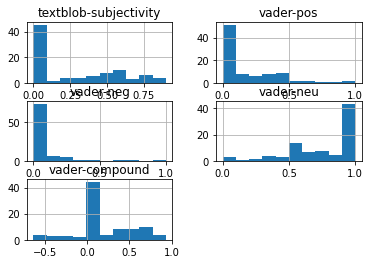

In [27]:
df_azure_speech.hist()

<AxesSubplot:xlabel='vader-polarity', ylabel='vader-compound'>

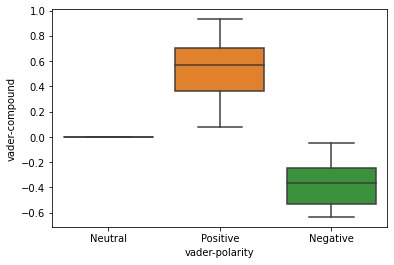

In [28]:
sns.boxplot(data=df_azure_speech, x="vader-polarity", y="vader-compound")

<AxesSubplot:ylabel='vader-polarity'>

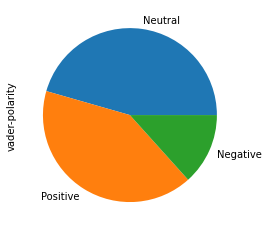

In [29]:
df_azure_speech['vader-polarity'].value_counts().plot(kind='pie')

In [30]:
df_azure_speech.sort_values('vader-compound').head(20)

,Sentence,Pre-processed sentence,textblob-subjectivity,vader-pos,vader-neg,vader-neu,vader-compound,vader-polarity,sentiment-category
78,What I didn't like was what I didn't like abou...,not like not like not like like go slowly load...,0.600000,0.202,0.366,0.432,-0.6333,Negative,[]
57,I would give all patients a nebula does not ha...,would give patient nebula not osusky good day ...,0.600000,0.106,0.298,0.596,-0.5417,Negative,[]
31,"But if I was looking for it there, I'm not sur...",look not sure average intelligent person look ...,0.729630,0.000,0.228,0.772,-0.5334,Negative,[]
30,Nothing to change the term nothing here is tha...,nothing change term nothing want another term ...,0.200000,0.000,0.242,0.758,-0.5334,Negative,[]
22,I was in trouble.,trouble,0.200000,0.000,1.000,0.000,-0.4019,Negative,[]
70,"What people write, so I'm very happy for the f...",people write happy fact option 2 thing doctor ...,0.622222,0.132,0.225,0.643,-0.3818,Negative,[]
20,"It's not easy, it's just this.",not easy,0.833333,0.000,0.706,0.294,-0.3412,Negative,[]
21,But here those who know in 1 of mine this way ...,know 1 mine way give advice oblige no late 40 ...,0.600000,0.000,0.155,0.845,-0.2960,Negative,[]
28,So the card cancels.,card cancel,0.000000,0.000,0.667,0.333,-0.2500,Negative,[]
89,Confusing experience really.,confusing experience really,0.300000,0.000,0.487,0.513,-0.2263,Negative,[]


In [31]:
df_azure_speech.sort_values('vader-compound', ascending=False).head(20)

,Sentence,Pre-processed sentence,textblob-subjectivity,vader-pos,vader-neg,vader-neu,vader-compound,vader-polarity,sentiment-category
16,That's what I wanted to tell you I don't know ...,want tell not know deadline need next availabl...,0.500758,0.389,0.000,0.611,0.9313,Positive,[]
12,But I see the address phone number there and I...,see address phone number see next free date,0.400000,0.726,0.000,0.274,0.8625,Positive,[]
56,Well edit the uh street it's I write the alice...,well edit uh street write alices city number b...,0.000000,0.412,0.000,0.588,0.8316,Positive,[]
87,Pleasant coloring is navigating me side here s...,pleasant coloring navigate side simple 4 easy ...,0.747619,0.551,0.000,0.449,0.8225,Positive,[]
79,There's a good thing there aren't useless arti...,good thing not useless article not useless not...,0.333333,0.558,0.000,0.442,0.7625,Positive,[]
27,2 days I'm going to cancel and I'm going to ch...,2 day go cancel go change deadline not know po...,0.575000,0.309,0.073,0.618,0.7585,Positive,[]
76,This question is how quickly the doctor would ...,question quickly doctor would answer example o...,0.433333,0.270,0.000,0.730,0.7430,Positive,[]
34,I also understand that the doctor will have so...,also understand doctor something example good ...,0.764286,0.330,0.095,0.575,0.7339,Positive,[]
80,The only thing I'd go into this discussion is ...,thing would go discussion sure not someone giv...,0.529630,0.341,0.130,0.528,0.7172,Positive,[]
69,It's good that it's easy to read and it's work...,good easy read work fast read every time alway...,0.677778,0.367,0.000,0.633,0.7003,Positive,[]
